In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, PandasTools, DataStructs
from rdkit.Chem.Draw import IPythonConsole

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

Using Theano backend.


In [2]:
df = PandasTools.LoadSDF( "cas_4337.sdf" )

RDKit ERROR: [22:58:00] ERROR: Counts line too short: '' on line306264


In [3]:
df[ "Target" ]  = np.where( df[ "Ames test categorisation" ] == "mutagen", 1, 0 )
fps = [ AllChem.GetMorganFingerprintAsBitVect( mol, 2, nBits=512, useFeatures=True ) for mol in df.ROMol ]

In [4]:
fparr = []
for fp in fps:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray( fp, arr )
    fparr.append( arr )
fparr = np.array( fparr )

In [5]:
Y = np.array( df.Target ) 
print( fparr.shape, Y.shape )

(4337, 512) (4337,)


In [6]:
trainx, testx, trainy, testy = train_test_split( fparr,
                                                 Y,
                                                 test_size = 0.2,
                                                 random_state=184 )
print(trainx.shape, testx.shape, trainy.shape)


(3469, 512) (868, 512) (3469,)


In [7]:
earlystopping = EarlyStopping( monitor='loss' )
model = Sequential()
model.add( Dense( input_dim=512, output_dim=200 ) )
model.add( Activation( "sigmoid" ) )
#model.add( Dropout(0.1) )
model.add( Dense( 200 ) )
model.add( Activation( "sigmoid" ) )
#model.add( Dropout(0.1) )
model.add( Dense( 2 ) )
model.add( Activation( "softmax" ) )


In [8]:
# sdg < adadelta < adagrad < adam
model.compile(  
               optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = [ 'accuracy' ]
             )

In [10]:
hist = model.fit( trainx,
                  np_utils.to_categorical( trainy ),
                  nb_epoch = 20,
                  batch_size = 100,
                  #callbacks=[ earlystopping ]
                )

Epoch 1/20
3469/3469 [==============================] - 0s - loss: 0.2393 - acc: 0.9060     
Epoch 2/20
3469/3469 [==============================] - 0s - loss: 0.2339 - acc: 0.9075     
Epoch 3/20
3469/3469 [==============================] - 0s - loss: 0.2300 - acc: 0.9124     
Epoch 4/20
3469/3469 [==============================] - 0s - loss: 0.2329 - acc: 0.9129     
Epoch 5/20
3469/3469 [==============================] - 0s - loss: 0.2252 - acc: 0.9164     
Epoch 6/20
3469/3469 [==============================] - 0s - loss: 0.2237 - acc: 0.9167     
Epoch 7/20
3469/3469 [==============================] - 0s - loss: 0.2246 - acc: 0.9199     
Epoch 8/20
3469/3469 [==============================] - 0s - loss: 0.2145 - acc: 0.9199     
Epoch 9/20
3469/3469 [==============================] - 0s - loss: 0.2153 - acc: 0.9184     
Epoch 10/20
3469/3469 [==============================] - 0s - loss: 0.2092 - acc: 0.9219     
Epoch 11/20
3469/3469 [==============================] - 0s - loss: 0

In [11]:
pred_y = model.predict_classes( testx )

640/868 [=====================>........] - ETA: 0s

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

In [13]:
print( confusion_matrix( testy, pred_y ) )

[[288 104]
 [ 73 403]]


In [14]:
print( classification_report( testy, pred_y ) )

             precision    recall  f1-score   support

          0       0.80      0.73      0.76       392
          1       0.79      0.85      0.82       476

avg / total       0.80      0.80      0.80       868



In [16]:
import matplotlib.pyplot as plt

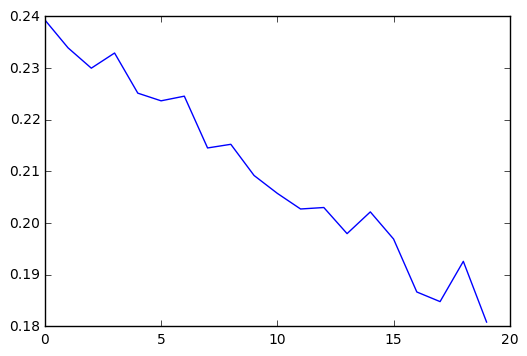

In [23]:
fig.clear()
loss = hist.history[ "loss" ]
acc = hist.history[ "acc" ]
plt.plot( range( 20 ), loss, label="loss" )

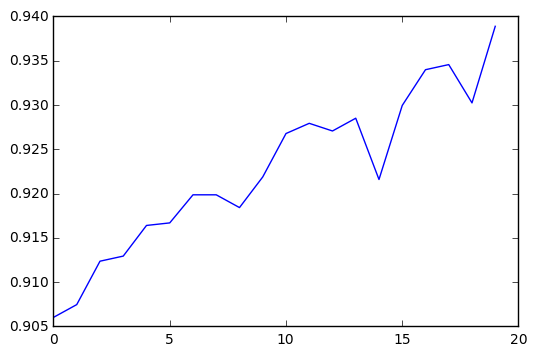

In [24]:
plt.plot( range( 20 ), acc, label="acc" )

In [25]:
# Vs RandomForest
rfc = RandomForestClassifier()
rfc.fit( trainx, trainy )

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [26]:
predy = rfc.predict( testx )

In [27]:
confusion_matrix( testy, predy )

array([[323,  69],
       [102, 374]])

In [28]:
# Oh!
print(classification_report( testy, predy ))

             precision    recall  f1-score   support

          0       0.76      0.82      0.79       392
          1       0.84      0.79      0.81       476

avg / total       0.81      0.80      0.80       868



In [ ]:
# まあまあですかね。おしまい。